Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [7]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [8]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '/home/victor/data' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified /home/victor/data/notMNIST_large.tar.gz
Found and verified /home/victor/data/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [9]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

/home/victor/data/notMNIST_large already present - Skipping extraction of /home/victor/data/notMNIST_large.tar.gz.
['/home/victor/data/notMNIST_large/A', '/home/victor/data/notMNIST_large/B', '/home/victor/data/notMNIST_large/C', '/home/victor/data/notMNIST_large/D', '/home/victor/data/notMNIST_large/E', '/home/victor/data/notMNIST_large/F', '/home/victor/data/notMNIST_large/G', '/home/victor/data/notMNIST_large/H', '/home/victor/data/notMNIST_large/I', '/home/victor/data/notMNIST_large/J']
/home/victor/data/notMNIST_small already present - Skipping extraction of /home/victor/data/notMNIST_small.tar.gz.
['/home/victor/data/notMNIST_small/A', '/home/victor/data/notMNIST_small/B', '/home/victor/data/notMNIST_small/C', '/home/victor/data/notMNIST_small/D', '/home/victor/data/notMNIST_small/E', '/home/victor/data/notMNIST_small/F', '/home/victor/data/notMNIST_small/G', '/home/victor/data/notMNIST_small/H', '/home/victor/data/notMNIST_small/I', '/home/victor/data/notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [17]:
folders = os.listdir(path=data_root+"/notMNIST_large/")

In [18]:
folders = [f for f in folders if not len(f)>1] #ajuste necessario depois que foi gerado os arquivos .pickle

In [19]:
folders.sort()

In [20]:
print(folders)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


## Mostrando uma imagem para cada letra, tomando o 3 arquivo listado pelo `os.listdir`

In [21]:
for folder in folders:
    a = os.listdir(path=os.path.join(data_root,"notMNIST_large",folder))
    display(Image(filename=os.path.join(data_root,"notMNIST_large",folder,a[2])))

## O mesmo que o feito acima, mas agora escolhendo um arquivo aleatoriamente em cada pasta

In [22]:
import random
for folder in folders:
    a = os.listdir(path=os.path.join(data_root,"notMNIST_large",folder))
    display(Image(filename=os.path.join(data_root,"notMNIST_large",folder,random.choice(a))))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [23]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

/home/victor/data/notMNIST_large/A.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_large/B.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_large/C.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_large/D.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_large/E.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_large/F.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_large/G.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_large/H.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_large/I.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_large/J.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_small/A.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_small/B.pickle already present - Skipping pickling.
/home/victor/data/notMNIST_small/C.pickle already pr

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

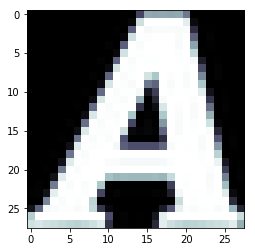

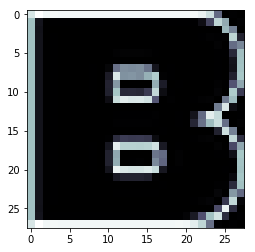

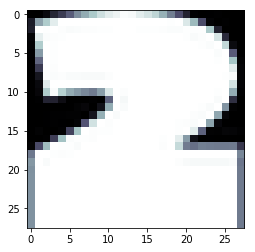

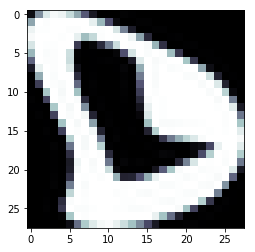

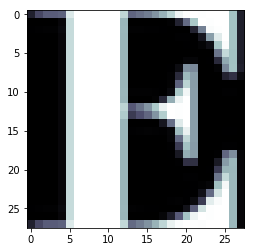

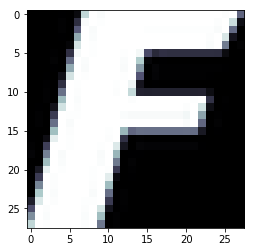

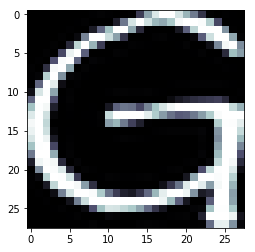

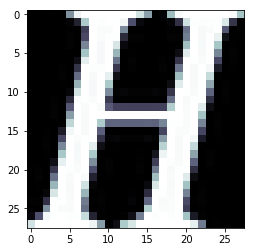

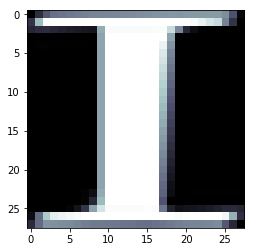

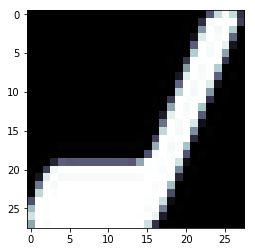

In [24]:
for pickle_file in train_datasets:
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)  # unpickle
        sample_idx = np.random.randint(len(letter_set))  # pick a random image index
        sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
        plt.figure()
        plt.imshow(sample_image, cmap=plt.cm.bone)  # display it

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

#### Para essa verificação basta verificar o tamanho de dados por classe, valor inclusive que já foi impresso quando as imagens foram juntadas nos arquivos `.pickle`

In [11]:
train_datasets_length = []
print("Tamanho do dataset de treino para cada classe(letra):")
for pickle_file in train_datasets:
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)  # unpickle
        train_datasets_length.append(len(letter_set))
        print(len(letter_set))
print("-------------")
print("Desvio padrão para o tamanho de cada dataset de treino:")
print(np.std(train_datasets_length))

Tamanho do dataset de treino para cada classe(letra):
52909
52911
52912
52911
52912
52912
52912
52912
52912
52911
-------------
Desvio padrão para o tamanho de cada dataset de treino:
0.916515138991


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [25]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [26]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [27]:
train_dataset.shape

(200000, 28, 28)

In [36]:
train_labels.shape

(200000,)

In [ ]:
train_dataset[0,:,:]

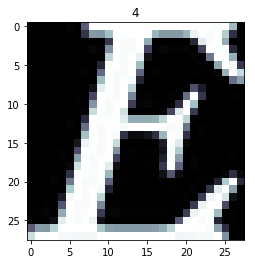

In [33]:
sample_image = train_dataset[0, :, :]  
plt.figure()
plt.title('{}'.format(train_labels[0]))
plt.imshow(sample_image, cmap=plt.cm.bone)  

### Cada classe (letra) está associada com uma letra: 0-9 = A - J

In [7]:
labels_dictionary = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

In [10]:
import random
def visualiza_dataset_label(dataset, label, num_images):
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        index_figure = random.randint(0,len(dataset))
        plt.title('{}'.format(labels_dictionary[label[index_figure]]))
        plt.imshow(dataset[index_figure], cmap=plt.cm.bone)
        plt.xticks([]);plt.yticks([])

Visualiza algumas figuras do dataset de treino


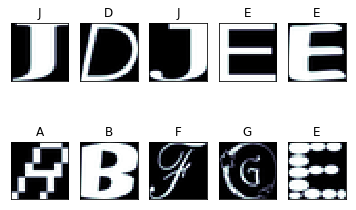

In [12]:
print("Visualiza algumas figuras do dataset de treino")
visualiza_dataset_label(train_dataset, train_labels, 10)

Visualiza algumas figuras do dataset de teste


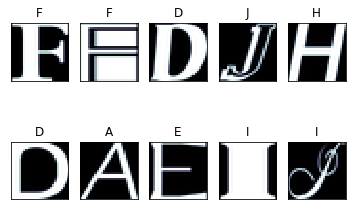

In [13]:
print("Visualiza algumas figuras do dataset de teste")
visualiza_dataset_label(test_dataset, test_labels, 10)

Finally, let's save the data for later reuse:

In [9]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [10]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800503


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

### Measure how much overlap there is between training, validation and test samples.

In [28]:
np.shape(train_dataset)

(200000, 28, 28)

In [86]:
i=8
indexes_equal_label_data1 = np.where(valid_labels == i)[0]
indexes_equal_label_data2 = np.where(test_labels == i)[0]

In [95]:
indexes_equal_label_data1.shape

(1000,)

In [94]:
indexes_equal_label_data1[0]

3

In [88]:
dataset1=valid_dataset
dataset2=test_dataset
overlap_dataset1 = {}
overlap_dataset2 = {}
for j in range(len(indexes_equal_label_data1)):
    data1_to_compare = dataset1[indexes_equal_label_data1[j], :, :]
    for k in range(len(indexes_equal_label_data2)):
        if np.array_equal(data1_to_compare, dataset2[indexes_equal_label_data2[k], :, :]):
            if not i in overlap_dataset1.keys():
                overlap_dataset1[i] = []
                overlap_dataset2[i] = []
            overlap_dataset1[i].append(indexes_equal_label_data1[j])
            overlap_dataset2[i].append(indexes_equal_label_data2[k])

In [96]:
overlap_dataset2[8]

[43,
 60,
 348,
 364,
 383,
 464,
 481,
 496,
 616,
 745,
 895,
 976,
 988,
 1095,
 1179,
 1182,
 1284,
 1295,
 1489,
 1522,
 1843,
 1900,
 1972,
 2205,
 2300,
 2402,
 2422,
 2464,
 2473,
 2519,
 2556,
 2596,
 2610,
 2650,
 2691,
 2726,
 2753,
 2830,
 2884,
 3211,
 3231,
 3250,
 3335,
 3579,
 3685,
 3832,
 3870,
 3912,
 3932,
 4077,
 4155,
 4211,
 4230,
 4250,
 4266,
 4342,
 4360,
 4389,
 4427,
 4720,
 4764,
 4773,
 4774,
 4835,
 4842,
 4898,
 4969,
 5041,
 5236,
 5248,
 5406,
 5432,
 5437,
 5604,
 5610,
 5694,
 5696,
 5699,
 5771,
 5819,
 6021,
 6104,
 6140,
 6158,
 6207,
 6379,
 6397,
 6493,
 6597,
 6613,
 6727,
 6770,
 6800,
 6906,
 7029,
 7064,
 7095,
 7097,
 7138,
 7147,
 7285,
 7319,
 7388,
 7399,
 7431,
 7520,
 7564,
 7597,
 7614,
 7641,
 7678,
 7704,
 7918,
 7972,
 7987,
 8111,
 8140,
 8259,
 8267,
 8571,
 8788,
 8890,
 8942,
 9118,
 9156,
 9171,
 9220,
 9266,
 9290,
 9441,
 9449,
 9516,
 9547,
 9556,
 9785,
 9793,
 9816,
 9850,
 9903,
 9906,
 43,
 60,
 348,
 364,
 383,
 464,
 

In [97]:
overlap_dataset1[8]

[52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,
 75,


In [102]:
data1_to_compare = dataset2[9906, :, :]
np.array_equal(data1_to_compare, dataset2[9903, :, :])

True

In [116]:
np.max(dataset1[75])

0.5

([], <a list of 0 Text yticklabel objects>)

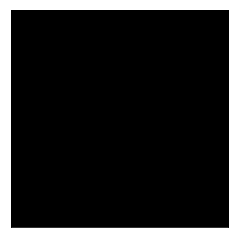

In [114]:
plt.imshow(dataset1[75], cmap=plt.cm.bone)
plt.xticks([]);plt.yticks([])

In [31]:
def find_overlap(dataset1, label_dataset1, dataset2, label_dataset2, number_classes):
    overlap_dataset1 = {}
    overlap_dataset2 = {}
    for i in range(number_classes):
        indexes_equal_label_data1 = np.where(label_dataset1 == i)[0]
        indexes_equal_label_data2 = np.where(label_dataset2 == i)[0]
        for j in range(len(indexes_equal_label_data1)):
            data1_to_compare = dataset1[indexes_equal_label_data1[j], :, :]
            for k in range(len(indexes_equal_label_data2)):
                if np.array_equal(data1_to_compare, dataset2[indexes_equal_label_data2[k], :, :]):
                    if not i in overlap_dataset1.keys():
                        overlap_dataset1[i] = []
                        overlap_dataset2[i] = []
                    overlap_dataset1[i].append(indexes_equal_label_data1[j])
                    overlap_dataset2[i].append(indexes_equal_label_data2[k])
    return overlap_dataset1, overlap_dataset2, np.sum([len(v) for v in overlap_dataset1.values()])
            

Para tentar melhorar a função acima depois, essa ajuda:
https://stackoverflow.com/questions/22583917/indices-in-a-numpy-array-where-slice-in-another-array

In [32]:
index_overlap_valid_test, index_overlap_test_valid, total_overlap_valid_test = find_overlap(valid_dataset, valid_labels, 
                                                                                 test_dataset, test_labels, 10)

In [36]:
for i in range(10):
    print(len(index_overlap_valid_test[i]))

7
4
9
11
6
5
12
8
12194
7


In [33]:
print('Total overlap para os dataset test e valid: {}'.format(total_overlap_valid_test))


Total overlap para os dataset test e valid: 12263


In [34]:
index_overlap_train_test, index_overlap_test_train, total_overlap_train_test = find_overlap(train_dataset, train_labels, 
                                                                                 test_dataset, test_labels, 10)

In [35]:
print('Total overlap para os dataset test e train: {}'.format(total_overlap_train_test))

Total overlap para os dataset test e train: 291320


In [37]:
for i in range(10):
    print(len(index_overlap_train_test[i]))

125
115
133
148
134
137
129
169
290107
123


### Aparentemente há algum errona função. O erro fica claro na verificação do overlap na penúltima classe. VERIFICAR!!! 

### Resta rodar esse. Como o dataset é muito grande, leva-se muito tempo...

In [ ]:
index_overlap_train_valid, index_overlap_valid_train, total_overlap_train_valid = find_overlap(train_dataset, train_labels, 
                                                                                 valid_dataset, valid_labels, 10)

In [ ]:
print('Total overlap para os dataset valid e train: {}'.format(total_overlap_train_valid))

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [15]:
logistic = LogisticRegression()

### 50 training samples

In [16]:
sample_size = 50
logistic.fit(train_dataset[0:sample_size, :, :].reshape((sample_size, image_size**2)), train_labels[0:sample_size])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
train_labels[0:sample_size]

array([4, 9, 6, 2, 7, 3, 5, 9, 6, 4, 7, 6, 0, 1, 8, 0, 1, 9, 6, 5, 4, 1, 8,
       7, 9, 8, 8, 2, 8, 9, 1, 4, 4, 8, 9, 7, 1, 7, 2, 5, 6, 1, 8, 6, 6, 0,
       3, 7, 5, 5], dtype=int32)

### "Returns the mean accuracy on the given test data and labels. " Ou seja, o quão acurada foi a classificação usada. Quanto mais próximo a 1, mais acurado foi o resultado treinamento. 

In [19]:
size_test, _, _ = test_dataset.shape
logistic.score(test_dataset.reshape((size_test,image_size**2)),test_labels)

0.70750000000000002

### 100 training samples

In [20]:
sample_size = 100
logistic.fit(train_dataset[0:sample_size, :, :].reshape((sample_size, image_size**2)), train_labels[0:sample_size])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Acurácia um pouco maior ao aumentar o número de amostras de treino

In [21]:
logistic.score(test_dataset.reshape((size_test,image_size**2)),test_labels)

0.75680000000000003

### 1000 training samples

In [22]:
sample_size = 1000
logistic.fit(train_dataset[0:sample_size, :, :].reshape((sample_size, image_size**2)), train_labels[0:sample_size])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Acurácia aumentou, porém ficou pouco acima de 80%. Ou seja, com 1000 amostras ainda não é suficiente para se atingir uma acurácia elevada mantendo-se os outros parâmetros.


In [23]:
logistic.score(test_dataset.reshape((size_test,image_size**2)),test_labels)

0.83999999999999997

### 5000 training samples

In [24]:
sample_size = 5000
logistic.fit(train_dataset[0:sample_size, :, :].reshape((sample_size, image_size**2)), train_labels[0:sample_size])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Mesmo com uma amostra 5 vezes maior que a anterior, a acurácia não se alterou muito. Aparentemente para esse estimador é preciso aumentar o tamanho do dataset em ao menos 10 vezes para uma melhorar significativa da acurácia. Vamos fazer um teste com um dataset um pouco maior, antes de usar todo o dado de treino disponível.

In [25]:
logistic.score(test_dataset.reshape((size_test,image_size**2)),test_labels)

0.84960000000000002

### 50000 training samples

In [26]:
sample_size = 50000
logistic.fit(train_dataset[0:sample_size, :, :].reshape((sample_size, image_size**2)), train_labels[0:sample_size])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Agora a acurácia chegou à 88%, tornando a estimativa razoável. O último teste será usar todo o dataset de treino para verificar se a acurácia melhorará significativamente.

In [27]:
logistic.score(test_dataset.reshape((size_test,image_size**2)),test_labels)

0.8851

## Agora usando todo o dataset de treino

In [28]:
sample_size, _, _ = train_dataset.shape
logistic.fit(train_dataset[0:sample_size, :, :].reshape((sample_size, image_size**2)), train_labels[0:sample_size])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Nota-se que não houve aumento significativo da acurácia ao usar todo o dataset ao invés de usar apenas 25% do mesmo. Claro que, considerando o tamanho total, mesmo 25% é uma quantidade considerável de dado para treino.

In [30]:
logistic.score(test_dataset.reshape((size_test,image_size**2)),test_labels)

0.89339999999999997

Uma drigressão para depois:

In [ ]:
"""Softmax."""

scores = [3.0, 1.0, 0.2]

import numpy as np

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    #pass  # TODO: Compute and return softmax(x)
    return np.exp(x)/np.sum(np.exp(x),0)

print(softmax(scores))

# Plot softmax curves
import matplotlib.pyplot as plt
x = np.arange(-2.0, 6.0, 0.1)
scores = np.vstack([x, np.ones_like(x), 0.2 * np.ones_like(x)])

plt.plot(x, softmax(scores).T, linewidth=2)
plt.show()